# INTRODUCTION

A mega-online shopping mall provides various baby brands to customers. In order to optimize online advertisements throughout websites, they want to predict the view-to-click probability given the information below.

The data consists of:

Action: the “interaction” that users completed when online ad was exposed. There are two types of actions in this dataset, View (a.k.a Impression) or Click. (Reference: https://en.wikipedia.org/wiki/Impression_(online_media))
ID: unique user IDs
Action Time: the time when action (View/Click) happened, in microseconds format
Website: the website where the ad was published
Banner Size: the banner size of ad
Brand: the brand name that the ad was promoting
Colour: the colour of product showcased in the ad
Interaction Time: user’s interaction time with each ad (sec)

Goal: Predict the Likelihood of Click

In [187]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [188]:
import pandas as pd
!pip install SQLAlchemy
!pip install pymysql
from sqlalchemy import create_engine
import pymysql
import configparser
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler,MinMaxScaler, RobustScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import make_pipeline,Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_curve, f1_score, precision_score, recall_score

In [189]:
## read data from ctrdata.csv
Origin = pd.read_csv('/content/drive/My Drive/website project/test3_data.csv')
Origin = Origin.set_index('Unnamed: 0')
Origin.head()

,ID,ActionTime,Action,Website,BannerSize,Brand,colour,InteractionTime
Unnamed: 0,,,,,,,,
1,AMsySZbNg8SBwPtj7IGHnip_8aY0,1508761859495365,View,Facebook,300x600,Carter's,Pink,0.171601
2,AMsySZZcUFNGOJs-lfC9j-ZDlV7Z,1502847469736117,View,Facebook,300x250,Burberry,Red,4.303945
3,AMsySZYoK8_bD0hGv4zu0iRn1TFo,1514169431528120,View,Facebook,728x90,Disney,Yellow,0.868106
4,AMsySZahxpwLOWnMJj6RGATgwEOc,1515527952591896,View,Facebook,320x50,Carter's,Yellow,0.802647
5,AMsySZbqgfMBDtAqZz1jVRaOmX00,1507514809374045,View,instagram.com,300x250,Gap,Gold,0.627148


# EDA & EXAMINATION

In [190]:
## Convert outcomes to 1 or 0 
Origin['Action'] = Origin['Action'].replace({'View':0,'Click':1})
Origin.head()

,ID,ActionTime,Action,Website,BannerSize,Brand,colour,InteractionTime
Unnamed: 0,,,,,,,,
1,AMsySZbNg8SBwPtj7IGHnip_8aY0,1508761859495365,0,Facebook,300x600,Carter's,Pink,0.171601
2,AMsySZZcUFNGOJs-lfC9j-ZDlV7Z,1502847469736117,0,Facebook,300x250,Burberry,Red,4.303945
3,AMsySZYoK8_bD0hGv4zu0iRn1TFo,1514169431528120,0,Facebook,728x90,Disney,Yellow,0.868106
4,AMsySZahxpwLOWnMJj6RGATgwEOc,1515527952591896,0,Facebook,320x50,Carter's,Yellow,0.802647
5,AMsySZbqgfMBDtAqZz1jVRaOmX00,1507514809374045,0,instagram.com,300x250,Gap,Gold,0.627148


In [191]:
## Detemine output, split testdata
from sklearn.model_selection import train_test_split
X = Origin.drop(columns=['Action'])
y = Origin['Action']

adX_train, adX_test, ady_train, ady_test = train_test_split(X, y, test_size=0.25)
adX_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 750000 entries, 8552 to 704722
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   ID               750000 non-null  object 
 1   ActionTime       750000 non-null  int64  
 2   Website          750000 non-null  object 
 3   BannerSize       750000 non-null  object 
 4   Brand            750000 non-null  object 
 5   colour           750000 non-null  object 
 6   InteractionTime  749993 non-null  float64
dtypes: float64(1), int64(1), object(5)
memory usage: 45.8+ MB


In [192]:
## Output distribution analysis
ady_train.value_counts(normalize=True)
## highly imbalance dataset

0    0.999756
1    0.000244
Name: Action, dtype: float64

In [193]:
## Feature Examination: ID 
adX_train['ID'].value_counts().describe()

count    190302.000000
mean          3.941104
std          12.413647
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max        1713.000000
Name: ID, dtype: float64

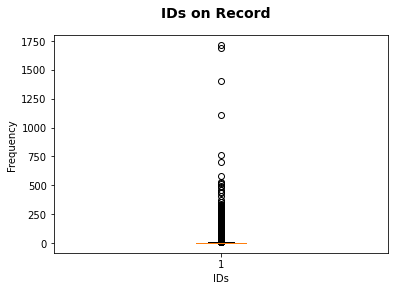

In [194]:
## Feature Examination: ID  
data = adX_train['ID'].value_counts()
# Boxplot the count of IDs
fig = plt.figure()
fig.suptitle('IDs on Record', fontsize=14, fontweight='bold')

ax = fig.add_subplot(111)
ax.boxplot(data)

ax.set_xlabel('IDs')
ax.set_ylabel('Frequency')

plt.show(); 
## Base on the ID analysis, the times of ad viewing by different users range from 1 to almost 1750 times

In [195]:
## Feature Examination: Datetime 
adX_train['ActionTime']
## the feature need to be converted to datime format

Unnamed: 0
8552      1508095021841120
500259    1514915161562649
992611    1505008764846797
62717     1510191958716247
319809    1503675914332154
                ...       
840157    1505002713405655
893988    1506091342899313
962594    1513250928198855
934438    1507134529633961
704722    1505091987162293
Name: ActionTime, Length: 750000, dtype: int64

In [196]:
## Feature Examination: BannerSize 
adX_train['BannerSize'].value_counts().index
## Need to convert the data from string to size numbers

Index(['300x250', '728x90', 'Other', '320x50', '300x600', '160x600',
       '1200x627', '1x1', '320x480', '300x50', '320x100', '768x1024',
       '750x125', '1536x2048', 'other'],
      dtype='object')

In [197]:
## Feature Examination: BannerSize 
# Convert Banner Size to area sizes, set size(other) to 0
adX_train['BannerSize'] = adX_train['BannerSize'].str.extract(r'(\d+)x').fillna(0).astype(int) * adX_train['BannerSize'].str.extract(r'x(\d+)').fillna(0).astype('int64')

## Convert 0 value to mean size value
Bannermean = adX_train['BannerSize'].mean()
adX_train['BannerSize'] = adX_train['BannerSize'].replace(0,Bannermean)




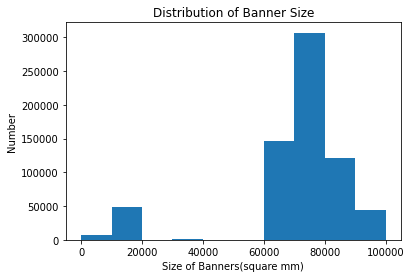

In [198]:
plt.title('Distribution of Banner Size')
plt.xlabel('Size of Banners(square mm)')
plt.ylabel('Number')
plt.hist(adX_train['BannerSize'],range=(0,100000)); 
## The Sizes can be further classified

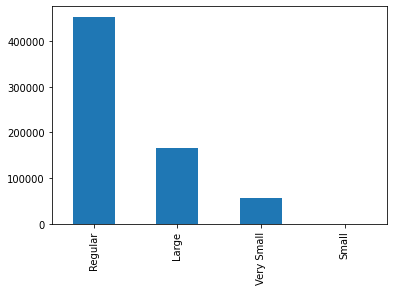

In [199]:
## Classify the Banner to different categories in terms of banner sizes
data = adX_train['BannerSize']
size = [0, 40000, 65000, 80000, 100000]

## If the Banner size is 50000, this is a small size
size_category = ['Very Small', 'Small', 'Regular', 'Large']
adX_train['SizeLabel'] = pd.cut(data, bins=size, labels=size_category)
adX_train['SizeLabel'].value_counts().plot(kind='bar');

In [200]:
## Feature Examination: Interaction Time
adX_train['InteractionTime'].describe()

count    749993.000000
mean          0.998408
std           0.998672
min           0.000002
25%           0.288329
50%           0.692552
75%           1.381555
max          13.385281
Name: InteractionTime, dtype: float64

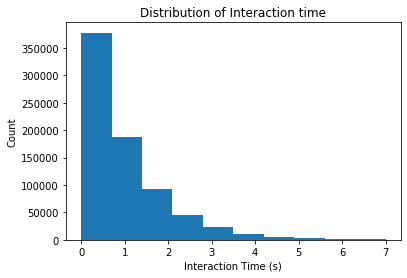

In [201]:
## Feature Examination: Interaction Time

plt.title('Distribution of Interaction time')
plt.xlabel('Interaction Time (s)')
plt.ylabel('Count')
plt.hist(adX_train['InteractionTime'],range=(0,7));


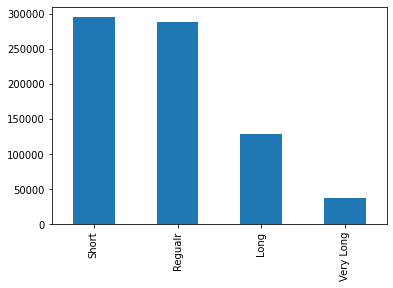

In [202]:
## Feature Examination: Interaction Time
## Classify the Interactin time to different time length categories
data1 = adX_train['InteractionTime']
itime = [0, 0.5, 1.5, 3, 15]


Length_category = ['Short', 'Regualr', 'Long', 'Very Long']
adX_train['InteractionLength'] = pd.cut(data1, bins=itime, labels=Length_category)
adX_train['InteractionLength'].value_counts().plot(kind='bar');

In [203]:
adX_train['Website'].value_counts()

Facebook         450077
Other             73206
Atedra            46233
instagram.com     42077
Craigslist.ca     29807
Yahoo             25267
TubeMogul         21408
Twitter           15763
Amazon            15411
Sympatico          8559
Kijiji             5889
Expedia            5202
Weather            3850
Youtube            3849
Wayfair            2985
AOL                 417
Name: Website, dtype: int64

In [204]:
adX_train['Brand'].value_counts()

Carter's                166821
JoeFresh                143952
Old Navy                112944
Banana Republic          62914
Disney                   62522
Burberry                 62434
gymboree                 52696
Zara                     41675
Gap                      23119
The Children's Place     20923
Name: Brand, dtype: int64

# FEATURE ENGINEERING

In [205]:
## Filling missing values
ITmean = adX_train['InteractionTime'].mean() 
adX_train['InteractionTime'] = adX_train['InteractionTime'].fillna(ITmean)

In [206]:
## Datetime Engineering
## Convert ActionTime to regular timestamp
adX_train['ActionTime']=pd.to_datetime(adX_train['ActionTime'].astype('float64')/10**6, unit='s')

In [207]:
## Classify the ActionTime timestamp to different seasons of a year
adX_train['month'] = pd.to_datetime(adX_train ['ActionTime']).dt.month
season = [-1, 3.1, 6.1, 9.1, 12.1]
## If the view action happen at 2:00 am, it is classified as late_night
season_name = ['Spring', 'Summer', 'Fall', 'Winter']
adX_train['Season'] = pd.cut(adX_train['month'], bins=season, labels=season_name)

## Classify the ActionTime timestamp to different periods of a day
adX_train['hr'] = pd.to_datetime(adX_train ['ActionTime']).dt.hour
time = [-1, 2.1, 6.1, 9.1, 11.1, 19.1, 24]
## If the view action happen at 2:00 am, it is classified as late_night
time_name = ['late_night', 'early_morning', 'morning', 'noon', 'afternoon', 'evening']
adX_train['Daysection'] = pd.cut(adX_train['hr'], bins=time, labels=time_name)


## Classify the ActionTime timestamp to either a weekday or weekend
def wd(a):
    if a==5 or a==6:
        b='weekend'
    else:
        b='weekday'
    return b

adX_train['Dayofweek'] = pd.to_datetime(adX_train ['ActionTime']).dt.dayofweek.apply(wd)



In [208]:
adX_test.shape

(250000, 7)

In [209]:
adX_train.shape

(750000, 14)

# ODINAL FEATURE ENGINEERING

In [137]:
## Engineering plan
original_feature = ['InteractionTime']
self_ordinal = ['ID','Website','Brand','colour','BannerSize']
target_odinal = ['Website','Brand','colour','BannerSize', 'Season', 'Dayofweek', 'Daysection']

In [217]:
## Self odinal engineering
X_train1 = adX_train.copy()
y_train = ady_train.copy()
for col in self_ordinal:
  feature_name = col+'_prob'
  prob = X_train1[col].value_counts(normalize=True).to_dict()
  X_train1[feature_name] = X_train1[col].map(prob)

X_train1 = X_train1.drop(columns=['ActionTime','SizeLabel','InteractionLength'])
X_train1.shape

(750000, 16)

In [212]:
X_train1.columns

Index(['ID', 'Website', 'BannerSize', 'Brand', 'colour', 'InteractionTime',
       'InteractionLength', 'month', 'Season', 'hr', 'Daysection', 'Dayofweek',
       'ID_prob', 'Website_prob', 'Brand_prob', 'colour_prob',
       'BannerSize_prob'],
      dtype='object')

In [ ]:
## Target odinal engineering
!pip install category_encoders
from category_encoders.woe import WOEEncoder as woe


     |████████████████████████████████| 82 kB 371 kB/s 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [218]:
woe_encoder = woe(cols=target_odinal,regularization=0.00000000001)
woe_encoder.fit(X_train1,y_train)
X_transformed = woe_encoder.transform(X_train1)

X_train = X_transformed.drop(columns=['ID','month','hr'])
X_train.shape

(750000, 13)

# FEATURE SELECTION

In [61]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import OneHotEncoder 
oh = OneHotEncoder() 
ros = RandomOverSampler(random_state=42,sampling_strategy=0.3)
rs = RobustScaler(with_centering=False)

model = LogisticRegression(penalty='l2',C=10,max_iter=100,class_weight = 'balanced')


X_resembled,y_resembled = ros.fit_resample(X_train,y_train) ## oversampling

y_lr = y_resembled
X_lr = pd.DataFrame(rs.fit_transform(X_resembled),columns=X_resembled.columns) ## robust scaler



model.fit(X_lr, y_lr)

LogisticRegression(C=10, class_weight='balanced')

In [62]:
len(model.coef_[0])

13

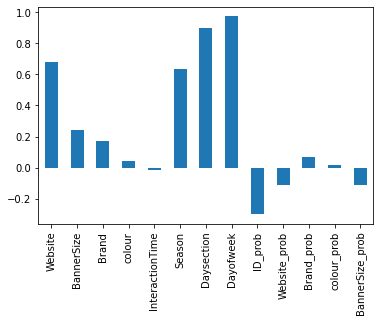

In [68]:
importance = pd.Series(model.coef_[0],index=X_lr.columns)
importance.plot(kind='bar');

In [69]:
X_resembled,y_resembled = ros.fit_resample(X_train,y_train) ## oversampling

y_xg = y_resembled

X_xg = pd.DataFrame(rs.fit_transform(X_resembled),columns=X_resembled.columns) ## robust scaler

# Create a XGboost model
from xgboost import XGBClassifier
# Params from: https://www.kaggle.com/aharless/swetha-s-xgboost-revised
clf_xgBoost = XGBClassifier(
    max_depth = 4,
    subsample = 0.8,
    colsample_bytree = 0.7,
    colsample_bylevel = 0.7,
    scale_pos_weight = 9,
    min_child_weight = 0,
    reg_alpha = 4,
    n_jobs = 4, 
    objective = 'binary:logistic'
)
# Fit the models
clf_xgBoost.fit(X_xg, y_xg)

XGBClassifier(colsample_bylevel=0.7, colsample_bytree=0.7, max_depth=4,
              min_child_weight=0, n_jobs=4, reg_alpha=4, scale_pos_weight=9,
              subsample=0.8)

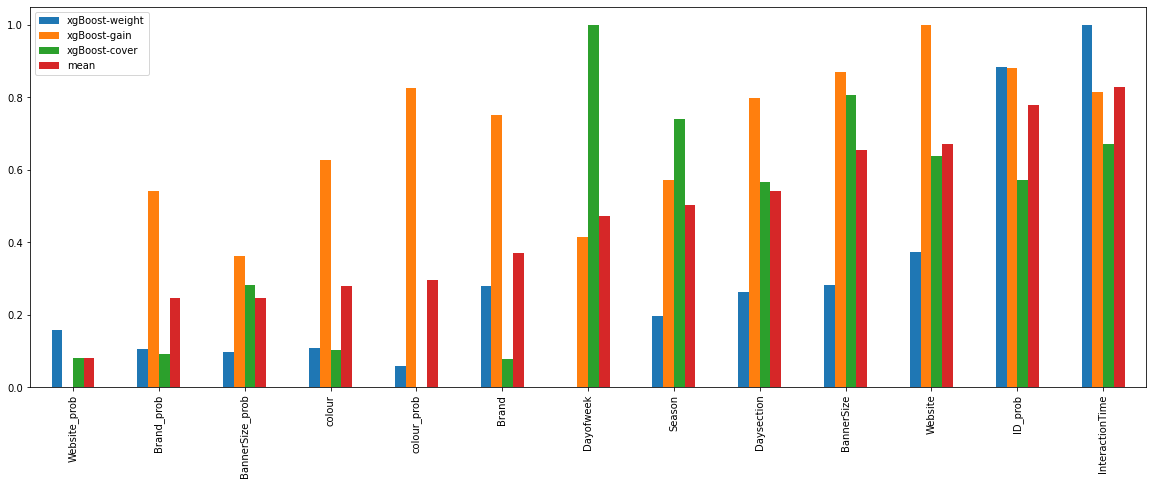

In [70]:
from sklearn import preprocessing

# Get xgBoost importances
importance_dict = {}
for import_type in ['weight', 'gain', 'cover']:
    importance_dict['xgBoost-'+import_type] = clf_xgBoost.get_booster().get_score(importance_type=import_type)
    
# MinMax scale all importances
importance_df = pd.DataFrame(importance_dict).fillna(0)
importance_df = pd.DataFrame(
    preprocessing.MinMaxScaler().fit_transform(importance_df),
    columns=importance_df.columns,
    index=importance_df.index
)

# Create mean column
importance_df['mean'] = importance_df.mean(axis=1)

# Plot the feature importances
importance_df.sort_values('mean').plot(kind='bar', figsize=(20, 7))

# TEST SET TRANSFORMATION

In [182]:
X_train.columns

Index(['Website', 'BannerSize', 'Brand', 'colour', 'InteractionTime', 'Season',
       'Daysection', 'Dayofweek', 'ID_prob', 'Website_prob', 'Brand_prob',
       'colour_prob', 'BannerSize_prob'],
      dtype='object')

In [183]:

def FeatureEngineering(X):
    ## Classify the ActionTime timestamp to different seasons of a year
    X['month'] = pd.to_datetime(X ['ActionTime']).dt.month
    season = [-1, 3.1, 6.1, 9.1, 12.1]
    ## If the view action happen at 2:00 am, it is classified as late_night
    season_name = ['Spring', 'Summer', 'Fall', 'Winter']
    X['Season'] = pd.cut(X['month'], bins=season, labels=season_name)

    ## Classify the ActionTime timestamp to different periods of a day
    X['hr'] = pd.to_datetime(X['ActionTime']).dt.hour
    time = [-1, 2.1, 6.1, 9.1, 11.1, 19.1, 24]
    ## If the view action happen at 2:00 am, it is classified as late_night
    time_name = ['late_night', 'early_morning', 'morning', 'noon', 'afternoon', 'evening']
    X['Daysection'] = pd.cut(X['hr'], bins=time, labels=time_name)


    ## Classify the ActionTime timestamp to either a weekday or weekend
    def wd(a):
        if a==5 or a==6:
            b='weekend'
        else:
            b='weekday'
        return b

    X['Dayofweek'] = pd.to_datetime(X['ActionTime']).dt.dayofweek.apply(wd)
    
    return X

In [213]:
X_test = FeatureEngineering(adX_test.copy()) 

X_test.columns

Index(['ID', 'ActionTime', 'Website', 'BannerSize', 'Brand', 'colour',
       'InteractionTime', 'month', 'Season', 'hr', 'Daysection', 'Dayofweek'],
      dtype='object')

In [83]:
## Engineering plan
original_feature = ['InteractionTime']
self_ordinal = ['ID','Website','Brand','colour','BannerSize']
target_odinal = ['Website','Brand','colour','BannerSize','Season', 'Dayofweek', 'Daysection']

In [214]:
## Self odinal engineering

y_test = ady_test.copy()
for col in self_ordinal:
  feature_name = col+'_prob'
  prob = X_test[col].value_counts(normalize=True).to_dict()
  X_test[feature_name] = X_test[col].map(prob)
X_test = X_test.drop(columns='ActionTime')
X_test.shape

(250000, 16)

In [216]:
X_train1.columns

Index(['ID', 'Website', 'BannerSize', 'Brand', 'colour', 'InteractionTime',
       'InteractionLength', 'month', 'Season', 'hr', 'Daysection', 'Dayofweek',
       'ID_prob', 'Website_prob', 'Brand_prob', 'colour_prob',
       'BannerSize_prob'],
      dtype='object')

In [215]:
X_test.columns

Index(['ID', 'Website', 'BannerSize', 'Brand', 'colour', 'InteractionTime',
       'month', 'Season', 'hr', 'Daysection', 'Dayofweek', 'ID_prob',
       'Website_prob', 'Brand_prob', 'colour_prob', 'BannerSize_prob'],
      dtype='object')

In [220]:
woe_encoder = woe(cols=target_odinal,regularization=0.00000000001)
woe_encoder.fit(X_train1,y_train)
X_transformed = woe_encoder.transform(X_test)
X_test = X_transformed.drop(columns=['ID','month','hr',])
X_test.head()

,Website,BannerSize,Brand,colour,InteractionTime,Season,Daysection,Dayofweek,ID_prob,Website_prob,Brand_prob,colour_prob,BannerSize_prob
Unnamed: 0,,,,,,,,,,,,,
426456,0.105216,0.0,0.100354,0.014882,3.847868,0.561852,0.296645,-0.514585,0.000060,0.600240,0.223256,0.160768,0.057392
758652,-0.719601,0.0,-0.422430,-0.047118,1.802634,0.561852,-0.723646,-0.514585,0.000032,0.055964,0.082732,0.139004,0.407536
27820,0.105216,0.0,0.100354,-0.052442,2.949029,0.561852,-0.038779,-0.514585,0.000032,0.600240,0.223256,0.183700,0.062244
664150,0.105216,0.0,0.319835,-0.237257,2.395143,0.561852,-0.723646,-0.514585,0.000064,0.600240,0.055616,0.055620,0.407536
208080,0.105216,0.0,-0.015476,0.014882,0.324221,0.561852,-0.723646,-0.514585,0.000032,0.600240,0.083648,0.160768,0.162648


In [230]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 750000 entries, 8552 to 704722
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Website          750000 non-null  float64
 1   BannerSize       750000 non-null  float64
 2   Brand            750000 non-null  float64
 3   colour           750000 non-null  float64
 4   InteractionTime  750000 non-null  float64
 5   Season           750000 non-null  float64
 6   Daysection       750000 non-null  float64
 7   Dayofweek        750000 non-null  float64
 8   ID_prob          750000 non-null  float64
 9   Website_prob     750000 non-null  float64
 10  Brand_prob       750000 non-null  float64
 11  colour_prob      750000 non-null  float64
 12  BannerSize_prob  750000 non-null  float64
dtypes: float64(13)
memory usage: 80.1 MB


In [231]:
X_test = X_test.fillna(0)

In [223]:

## inputs and test sets
[X_train.shape, X_test.shape, y_train.shape, y_test.shape]

[(750000, 13), (250000, 13), (750000,), (250000,)]

# MACHINE LERNING MODEL DEVELOPMENT

In [ ]:
## Use randomforest

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
ros = RandomOverSampler(random_state=42)
##X_resampled_click, y_resampled_click = ros.fit_resample(X_input_click, y_input_click)
from sklearn.decomposition import PCA


## use GridSearch to tune the hyperparameters
pipe = Pipeline([
    ##('OHE', OneHotEncoder()),
      ##('Smote',SMOTE()),
        ##('o', ros), 
     ##('u', RandomUnderSampler()),
     ##('scaling', MaxAbsScaler()),
     ##('scaling', RobustScaler()),
     ('scaling', StandardScaler(with_mean=False)),
    ##('simpleimputer', SimpleImputer()),
    ##('DT', DecisionTreeClassifier())
    ##('LR', LogisticRegression())
    ##('PCA', PCA(0.9)),
    ('rf', RandomForestClassifier())
    
        
])

parameters = {
    ##'u__sampling_strategy':[0.8],
    ##'clf__dt__max_depth':  [10, 20],
    ##'clf__knn__n_neighbors': [5, 7],
    ##'clf__lr__penalty':  ['l2'],
    ##'clf__lr__C':  [20.0, 5.0, 1.0],
    'rf__max_depth':  [10,20],
    ##'clf__xgb__max_depth':  [3,5],
    ##'LR__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga' ]
}


gs = GridSearchCV(pipe, parameters, cv=3, scoring='f1', n_jobs=2, verbose=4)

gs.fit(X_input, y_input)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('OHE', OneHotEncoder()),
                                       ('u', RandomUnderSampler()),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=2,
             param_grid={'rf__max_depth': [10, 20],
                         'u__sampling_strategy': [0.8]},
             scoring='f1', verbose=4)

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier


estimators = [
    ##('knn', KNeighborsClassifier(n_neighbors=5)),
    ##('dt', DecisionTreeClassifier()),
    ##('lr', LogisticRegression()),
    ('rf', RandomForestClassifier()),
    ('xgb', XGBClassifier(max_depth=3,min_child_weight=1.5))
]

clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression(penalty='l2',C=5)
)

In [ ]:
from sklearn.preprocessing import OneHotEncoder
ros = RandomOverSampler(random_state=42)
##X_resampled_click, y_resampled_click = ros.fit_resample(X_input_click, y_input_click)
from sklearn.decomposition import PCA
from sklearn.preprocessing import MaxAbsScaler
## use GridSearch to tune the hyperparameters
pipe = Pipeline([
    ('OHE', OneHotEncoder()),
      ##('Smote',SMOTE()),
        ##('o', ros), 
        ('u', RandomUnderSampler()),
     ('scaling', MaxAbsScaler()),
     ##('scaling', RobustScaler()),
     ##('scaling', StandardScaler(with_mean=False)),
    ##('simpleimputer', SimpleImputer()),
    ##('DT', DecisionTreeClassifier())
    ##('LR', LogisticRegression())
    ##('PCA', PCA(0.9)),
    ('clf', clf)
    
        
])

parameters = {
    'u__sampling_strategy':[0.8,0.5,0.3],
    ##'clf__dt__max_depth':  [10, 20],
    ##'clf__knn__n_neighbors': [5, 7],
    ##'clf__lr__penalty':  ['l2'],
    ##'clf__lr__C':  [20.0, 5.0, 1.0],
    'clf__rf__max_depth':  [10,20,30,50],
    'clf__xgb__max_depth':  [3,5],
    ##'LR__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga' ]
}


gs = GridSearchCV(pipe, parameters, cv=3, scoring='f1', n_jobs=2, verbose=4)

gs.fit(X_input, y_input)
## not enough time to finish running this

Fitting 3 folds for each of 24 candidates, totalling 72 fits


KeyboardInterrupt: ignored

In [224]:
from sklearn.preprocessing import OneHotEncoder
ros = RandomOverSampler(random_state=42,sampling_strategy=0.3)
##X_resampled_click, y_resampled_click = ros.fit_resample(X_input_click, y_input_click)
##from sklearn.decomposition import PCA

## use GridSearch to tune the hyperparameters
pipe = Pipeline([
      ##('OHE', OneHotEncoder()),
      ##('Smote',SMOTE()),
       ('o', ros), 
        ##('u', rus),
     ## ('scaling', MaxAbsScaler()),
     ('scaling', RobustScaler(with_centering=False)),
     ##('scaling', StandardScaler()),
    ##('simpleimputer', SimpleImputer()),
    ##('DT', DecisionTreeClassifier())
    ##('LR', LogisticRegression())
    ##('PCA', PCA(0.9)),
    ('lr', LogisticRegression(class_weight = 'balanced'))
    
        
])

parameters = {
    ##'o__sampling_strategy':[0.8],
    ##'clf__dt__max_depth':  [10, 20],
    ##'clf__knn__n_neighbors': [5, 7],
    'lr__penalty':  ['l2'],
    'lr__C':  [1,5.0,10],
    'lr__max_iter':[50,60,70,80,100]
}


gs = GridSearchCV(pipe, parameters, cv=10, scoring='f1', n_jobs=-1, verbose=4)

gs.fit(X_train, y_train)

Fitting 10 folds for each of 15 candidates, totalling 150 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('o',
                                        RandomOverSampler(random_state=42,
                                                          sampling_strategy=0.3)),
                                       ('scaling',
                                        RobustScaler(with_centering=False)),
                                       ('lr',
                                        LogisticRegression(class_weight='balanced'))]),
             n_jobs=-1,
             param_grid={'lr__C': [1, 5.0, 10],
                         'lr__max_iter': [50, 60, 70, 80, 100],
                         'lr__penalty': ['l2']},
             scoring='f1', verbose=4)

In [225]:
gs.best_params_



{'lr__C': 1, 'lr__max_iter': 50, 'lr__penalty': 'l2'}

In [226]:
best_model = gs.best_estimator_


In [227]:
#define a default treshold 0.5 probability for identification
def treshold(pred):
    if pred <= 0.5:
        return 0
    else:
        return 1

## develop a function which evaluates the model using  4 different matrices
def assess_model(model):
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    print('Accuracy: %f' % accuracy)
    print()
    f1 = f1_score(y_test, predictions)
    print('F1 score: %f' % f1)
    print()
    precision = precision_score(y_test, predictions)
    print('Precision_score : %f' % precision)
    print()
    recall = recall_score(y_test, predictions)
    print('Recall_score: %f' % recall)
    print()
    print('Confusion matrix')
    cm = confusion_matrix(y_true=y_test, y_pred=predictions)
    print(cm)

In [ ]:
y_test.value_counts()

0    249949
1        51
Name: Action, dtype: int64

In [233]:
pd.Series(best_model.predict(X_test)).value_counts()

0    178533
1     71467
dtype: int64

In [232]:
assess_model(best_model)

Accuracy: 0.714192

F1 score: 0.001063

Precision_score : 0.000532

Recall_score: 0.622951

Confusion matrix
[[178510  71429]
 [    23     38]]


In [229]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250000 entries, 426456 to 702679
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Website          250000 non-null  float64
 1   BannerSize       250000 non-null  float64
 2   Brand            250000 non-null  float64
 3   colour           250000 non-null  float64
 4   InteractionTime  249999 non-null  float64
 5   Season           250000 non-null  float64
 6   Daysection       250000 non-null  float64
 7   Dayofweek        250000 non-null  float64
 8   ID_prob          250000 non-null  float64
 9   Website_prob     250000 non-null  float64
 10  Brand_prob       250000 non-null  float64
 11  colour_prob      250000 non-null  float64
 12  BannerSize_prob  250000 non-null  float64
dtypes: float64(13)
memory usage: 26.7 MB
